In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
%matplotlib inline
import sklearn
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate as cv
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn import metrics as mtr

In [2]:
train = pd.read_csv('train.csv',engine = 'python', encoding = 'utf-8')
stadium = pd.read_csv('stadium_capacity_mapping.csv',engine = 'python', encoding = 'utf-8')
match = pd.read_csv('match_reports.csv',engine = 'python', encoding = 'utf-8')
holidays = pd.read_csv('holidays_in_japan.csv',engine = 'python', encoding = 'utf-8')
holidays.columns = ['match_date', 'description']
teams_df = pd.read_csv('teams.csv', encoding='shift-jis')
test = pd.read_csv('test.csv',engine = 'python', encoding = 'shift-jis')

Text(0.5,1,'attendance distribution')

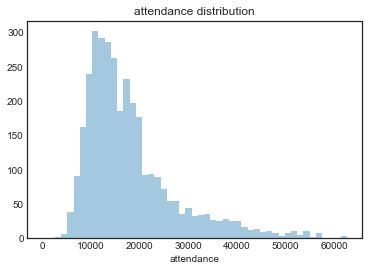

In [3]:
sns.distplot(train.attendance, kde=False)
plt.title('attendance distribution')

In [4]:
train[(train.attendance > 60000) | (train.attendance < 2000)]

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,attendance
298,9488,2006-12-02,14:04,第34節,第1日,浦和,G大阪,埼玉スタジアム2002,晴,15.6,34,テレ玉/NHK総合/J SPORTS(録),62241
594,10273,2007-11-24,14:04,第33節,第1日,浦和,鹿島,埼玉スタジアム2002,晴,13.1,43,スカパー!(パーフェクト チョイス)/e2(スカチャン!HV)/テレ玉/NHK総合,62123
614,10805,2008-03-08,14:05,第1節,第1日,横浜FM,浦和,日産スタジアム,晴,11.9,31,スカパー!・e2(TBSチャンネル)/TBS(単),61246
2433,15127,2013-11-30,14:04,第33節,第1日,横浜FM,新潟,日産スタジアム,晴,12.7,33,スカパー!/スカパー!プレミアムサービス/NHK総合,62632
2479,15699,2014-03-23,15:04,第4節,第1日,浦和,清水,埼玉スタジアム2002,晴,16.2,23,スカパー!/スカパー!プレミアムサービス/テレ玉,0


In [5]:
# exclude collapsing data
train=train[train['attendance']!=0]

In [6]:
# concatenate train and test data
Y_train = train['attendance']
total = pd.concat([train.drop('attendance', axis=1), test])

In [7]:
# import other files
files = glob.glob('winningpoint/*.csv')
cols = ['ID', ' home_place',' away_place',' home_dummy',' away_dummy',' home_condition',' away_condition']
winning = pd.DataFrame(index=[], columns=cols)
for file in files:
    win = pd.read_csv(file)
    winning=pd.concat([winning, win])
winning = winning.rename(columns = {'ID': 'id'})
total = pd.merge(total, winning, how = 'left', on = 'id')

files = glob.glob('stars/*.csv')
cols = ['id', ' home_star',' away_star']
star = pd.DataFrame(index=[], columns=cols)
for file in files:
    s = pd.read_csv(file)
    star=pd.concat([star, s])
total = pd.merge(total, star, how = 'left', on = 'id')

total = total.merge(right=stadium, how="left", left_on="venue", right_on="stadium").drop("stadium", axis=1)

In [8]:
# convert to datetime type
total.loc[:, 'match_date'] = pd.to_datetime(total['match_date'])
total.loc[:, 'kick_off_time'] = pd.to_datetime(total['kick_off_time'])
holidays['match_date'] = pd.to_datetime(holidays['match_date'])
total['match_date_year'] = total['match_date'].dt.year
total['match_date_month'] = total['match_date'].dt.month
total['match_date_day'] = total['match_date'].dt.day
total['match_date_dayofweek'] = total['match_date'].dt.dayofweek
total['kick_off_time_hour'] = total['kick_off_time'].dt.hour

# add holidays data to total
holidays = holidays.rename(columns = {'description': 'holiday'})
total = pd.merge(total, holidays, how='left', on = 'match_date')
total.holiday = total.holiday.fillna(0)
total.holiday = (total.holiday != 0) * 1

In [9]:
total

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,...,away_star,home_star,ID,capacity,match_date_year,match_date_month,match_date_day,match_date_dayofweek,kick_off_time_hour,holiday
0,9190,2006-03-04,2019-01-10 16:04:00,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,...,NaN,NaN,NaN,21000,2006,3,4,5,16,0
1,9191,2006-03-05,2019-01-10 13:00:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,...,NaN,NaN,NaN,15859,2006,3,5,6,13,0
2,9192,2006-03-05,2019-01-10 13:35:00,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,...,NaN,NaN,NaN,48999,2006,3,5,6,13,0
3,9193,2006-03-05,2019-01-10 14:04:00,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,...,NaN,NaN,NaN,51697,2006,3,5,6,14,0
4,9194,2006-03-05,2019-01-10 14:04:00,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,...,NaN,NaN,NaN,20223,2006,3,5,6,14,0
5,9195,2006-03-05,2019-01-10 15:03:00,第1節,第2日,大宮,千葉,埼玉スタジアム2002,晴,12.6,...,NaN,NaN,NaN,62010,2006,3,5,6,15,0
6,9196,2006-03-05,2019-01-10 15:00:00,第1節,第2日,川崎F,新潟,等々力陸上競技場,晴,13.3,...,NaN,NaN,NaN,26827,2006,3,5,6,15,0
7,9197,2006-03-05,2019-01-10 15:06:00,第1節,第2日,広島,鹿島,広島ビッグアーチ,曇,12.4,...,NaN,NaN,NaN,36894,2006,3,5,6,15,0
8,9198,2006-03-05,2019-01-10 15:35:00,第1節,第2日,横浜FM,京都,日産スタジアム,晴,12.6,...,NaN,NaN,NaN,72081,2006,3,5,6,15,0
9,9199,2006-03-11,2019-01-10 14:04:00,第2節,第1日,浦和,磐田,埼玉スタジアム2002,晴,16.0,...,NaN,NaN,NaN,62010,2006,3,11,5,14,0


In [10]:
# only extract the numbers of section and round
total.loc[:, 'section'] = total.loc[:, 'section'].apply(lambda x: int(x[1:-1]))
total.loc[:, 'round'] = total.loc[:, 'round'].apply(lambda x: int(x[1:-1]))

In [12]:
# unify team names
def team_name_unify(s):
    if s == 'Ｃ大阪':
        return 'C大阪'
    elif s == 'Ｇ大阪':
        return 'G大阪'
    elif s == '川崎Ｆ':
        return '川崎F'
    else:
        return s

for i in range (len(total)):
    home = total.at[i, 'home_team']
    away = total.at[i, 'away_team']
    total.at[i, 'home_team'] = team_name_unify(home)
    total.at[i, 'away_team'] = team_name_unify(away)

In [13]:
# convert playing team info to dummy variables
teamlist = set(total['home_team'].unique().tolist() + total['away_team'].unique().tolist())
for team in teamlist:
    total[team] = (total['home_team'] == team) | (total['away_team'] == team)

In [14]:
# convert weather info to dummy variables
for condition in ['晴', '曇', '雨', '屋内', '雷', '雪', '霧']:
    total[condition] = total.weather.str.contains(condition)

In [15]:
# acquire broadcasters' info
import re
raw_channels = set()
for channels in total["broadcasters"].str.split("/"):
    raw_channels.update(channels)
new_channels = set()

def convert(channel):
    channel = channel.upper()
    channel = ((channel.split('※')[0]).split('(')[0]).rstrip(' ').rstrip('*').replace('ー', '-').replace(' ', '_')
    if channel[:2] == 'スカ':
        channel = 'スカパー'
    return channel

for channel in raw_channels:
    new_channels.add(convert(channel))

total['broadcasters'] = total['broadcasters'].str.split('/').apply(lambda x: [convert(y) for y in x])
for channel in new_channels:
    total[channel] = total['broadcasters'].apply(lambda x: channel in x)

In [16]:
# delete small broadcasters
for channel in total.columns[66:].tolist():
    if sum(total[channel].values) < 5:
        total = total.drop(channel,axis=1)

In [17]:
# if the game was during the summer vacation
summer=[]
for i in range (len(total)):
    if (total.at[i, 'match_date_month'] == 8) or (total.at[i, 'match_date_month'] == 7 and total.at[i, 'match_date_day'] > 20):
        summer.append(1)
    else:
        summer.append(0)
total['summer_vacation'] = summer

In [18]:
# add info about teams revenue to total
teams_df = teams_df.rename(columns = {'team':'home_team'})
total = pd.merge(total, teams_df, how='left', on='home_team')
total = total.rename(columns = {'income_16':'home_scale', 'place':'home', 'region':'home_region'})
teams_df = teams_df.rename(columns = {'home_team':'away_team'})
total = pd.merge(total, teams_df, how='left', on='away_team')
total = total.rename(columns = {'income_16':'away_scale', 'place':'away', 'region':'away_region'})

In [19]:
# if the game was derby game. if the access between two places are good or bad
total['derby'] = (total.home == total.away)*1
total['access'] = (total.home_region == total.away_region)*1

C:\Users\toshi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


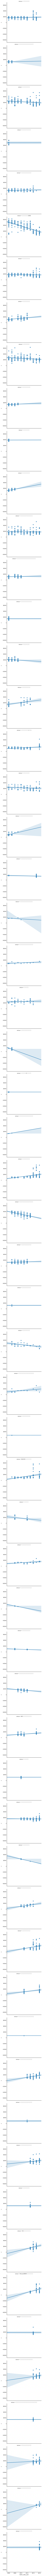

In [20]:
# see if there is any change in the number of attendance in each stadium in years
num_train = len(Y_train)
eda = total[:num_train]
eda['y'] = Y_train
sns.lmplot('match_date_year', 'y', eda, row='venue')

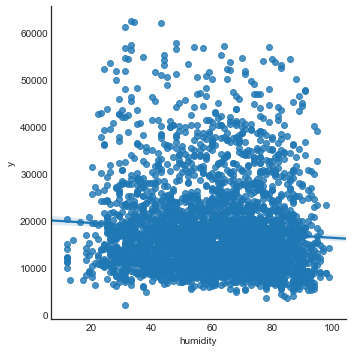

In [21]:
sns.lmplot('humidity', 'y', eda)

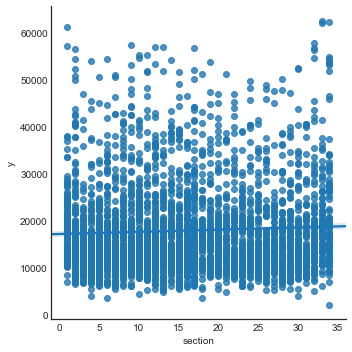

In [22]:
sns.lmplot('section', 'y', eda)

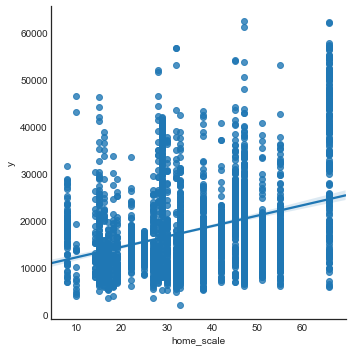

In [23]:
sns.lmplot('home_scale', 'y', eda)

In [24]:
X = total.drop('id', axis=1)
X = X.drop('match_date', axis=1)
X = X.drop('kick_off_time', axis=1)
X = X.drop('venue', axis=1)
X = X.drop('weather', axis=1)
X = X.drop('home_team', axis=1)
X = X.drop('away_team', axis=1)
X = X.drop('broadcasters', axis=1)
X = X.drop('home', axis=1)
X = X.drop('home_region', axis=1)
X = X.drop('away', axis=1)
X = X.drop('away_region', axis=1)

In [26]:
X_train = X.iloc[:3365]
X_test = X.iloc[3365:]

In [29]:
from sklearn.grid_search import GridSearchCV
params = {"learning_rate":[0.08, 0.1,0.15, 0.2,0.3],
        "max_depth": [3,5,6,7],
         "subsample":[0.5,0.8,0.9,1],
         "colsample_bytree": [0.5,1.0],
         }
# モデルにインスタンス生成
model = xgb.XGBRegressor()
# ハイパーパラメータ探索
cv = GridSearchCV(model, params, cv = 10, scoring= 'explained_variance', n_jobs =-1)

cv.fit(X_train.values, Y_train)
print('Best parameters: {}'.format(cv.best_params_))
print('Best cross-validation: {}'.format(cv.best_score_))

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.9}
Best cross-validation: 0.8236298161890566


In [30]:
predict = cv.predict(X_test.values)
submit = pd.read_csv('sample_submit.csv',engine = 'python', encoding = 'utf-8', header=None)
submit = submit.ix[:,:0]
submit['prediction'] = predict
count = 0
pred = []
X_test = X_test.reset_index()
X_test = X_test.drop('index',axis=1)
for i in range (len(submit)):
    if submit.loc[i, 'prediction'] > X_test.loc[i, 'capacity']:
        count += 1
        pred.append(X_test.loc[i, 'capacity'])
    else:
        pred.append(submit.loc[i, 'prediction'])
submit['prediction'] = pred
submit.to_csv('submit.csv', header=False, index=False)

C:\Users\toshi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
